Описание задания:

Во вложении дата сет для построения классификационной модели.
Необходимо построить модель, предсказывающую класс (столбец B) по имеющимся признакам (столбцы C-EA). Кроме того, можете построить модель предсказывающую возраст (столбец C) по имеющимся признакам (столбцы D-EA). 

Пропусков данных в таблице нет. Можете использовать любые инструменты машинного обучения. 
В качестве результата можете направить достингутые параметры модели (можете использовать данный датасет и для трейна, и для теста), а также перечень наиболее значимых признаков (фичей) для использования в построении моделей.

<a name="1common."></a>
## Содержание:
* [Шаг 1. Загрузим данные и подготовимся к их анализу](#1.)
* [Шаг 2. Предобработка данных](#2.)
* [Шаг 3. Исследовательский анализ.](#3.)
     - [3.1 Анализ возрастных групп](#3.1)
     - [3.2 Категоризация возрастных групп](#3.2)
* [Шаг 4. Построение прогнозных моделей](#4.)     
     - [4.1 Определение лучшей модели для построения](#4.1)
     - [4.2 Построение модели градиентный бустинг](#4.2)
     - [4.3 Построение модели логистической регрессии](#4.3)
     - [4.4 Выводы по построенным моделям для целевого классификатора](#4.4)
     - [4.5 Прогнозное отнесение к возрастной группе по имеющимся признакам](#4.5)
* [Шаг 5. Выводы по проекту](#5.)

<a name="1."></a><br/>
<font size="5"><b>1. Загрузим данные и подготовимся к их анализу</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [1]:
import time
# импорт библиотеки pandas
import pandas as pd 
from pandas import DataFrame

# импортируем библиотеки для мат.расчетов
import numpy as np
from collections import Counter

# библиотеки для визуализации
import matplotlib.pyplot as plt
#from matplotlib import colors
import seaborn as sns
import plotly.express as px

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_excel('/home/catfox/test_DS.xlsx')
df.head()

id  class  age  feature 1  feature 2  feature 3  feature 4  feature 5  \
0   1      0   13   0.506822   0.572237   0.563280   0.564596   0.673946   
1   2      0   13   0.634540   0.656879   0.661679   0.514073   0.597017   
2   3      1   13   0.500905   0.645632   0.651043   0.529001   0.658857   
3   4      0   13   0.493149   0.599626   0.761525   0.569928   0.550057   
4   5      0   13   0.520421   0.664441   0.572142   0.555681   0.627189   

   feature 6  feature 7  ...  feature 119  feature 120  feature 121  \
0   1.000000   0.639703  ...     0.659633     0.554634     0.606054   
1   0.653414   0.613749  ...     0.592704     0.809567     0.652914   
2   0.803911   0.684024  ...     0.574472     0.570743     0.729069   
3   0.724291   0.546091  ...     0.602609     0.589338     0.736556   
4   0.633925   0.546091  ...     0.602609     0.602220     0.637908   

   feature 122  feature 123  feature 124  feature 125  feature 126  \
0     0.535127     0.592213     0.646772     0.578132     0.409359   
1     0.492657     0.634188     0.966302     0.713014     0.484816   
2     0.491912     0.668273     0.694074     0.594661     0.509790   
3     0.585193     0.730247     0.712183     0.630339     0.633105   
4     0.554012     0.588330     0.745618     0.560864     0.475226   

   feature 127  feature 128  
0     0.617043     0.684861  
1     0.665300     0.641281  
2     0.687504     0.643744  
3     0.753155     0.463349  
4     0.590734     0.642919  

[5 rows x 131 columns]

In [3]:
# узнаем размерность исходника
df.shape

(4704, 131)

In [4]:
# узнаем типы данных исходника
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4704 entries, 0 to 4703
Columns: 131 entries, id to feature 128
dtypes: float64(128), int64(3)
memory usage: 4.7 MB


Резюме:
На вход имеем датафрейм с 4704 строк и 131 столбец.

Какие столбцы имеем:
* id - уникальный номер наблюаемого
* class - целевой класс, имеющий бинарный признак 0,1
* age -  возраст наблюдаемого
* feature 1 - feature 128 - набор признаков

3 столбца имеют числовой тип данных, визуально это id, class, age.

Столбцы feature 1 - feature 128 имеют тип float64.

Для начала проверим/исправим следующие:

1. Не все названия столбцов отображаются, поэтому проверим действительно ли количество столбцов с признаками feature равно 128.
2. В наименовании столбцов, есть пробелы, избавимся от них.
3. Целевой столбец class имеет совпадение имени со встроенным оператором класса, поэтому его тоже переименуем.
4. Проверим наны(по условию их нет, но это секундная проверка) и дубликаты.


Проверим и исправим.

<a name="2."></a><br/>
<font size="5"><b>2. Предобработка данных</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [5]:
# сделаем список из наименования колонок
list_of_columns_name = df.columns.tolist()
# переменная для счетчика
cnt = 0
# cловарь для переименовки колонок
dict_of_columns = {'class':'klass'}
for name in list_of_columns_name:
    if 'feature ' in name:
        cnt += 1
        dict_of_columns[name] = name.replace(" ", "") # replace избавляет нас от пробелов
print ('Количество столбцов с признаками', cnt)
df = df.rename(columns = dict_of_columns)
df.head()

Количество столбцов с признаками 128


id  klass  age  feature1  feature2  feature3  feature4  feature5  feature6  \
0   1      0   13  0.506822  0.572237  0.563280  0.564596  0.673946  1.000000   
1   2      0   13  0.634540  0.656879  0.661679  0.514073  0.597017  0.653414   
2   3      1   13  0.500905  0.645632  0.651043  0.529001  0.658857  0.803911   
3   4      0   13  0.493149  0.599626  0.761525  0.569928  0.550057  0.724291   
4   5      0   13  0.520421  0.664441  0.572142  0.555681  0.627189  0.633925   

   feature7  ...  feature119  feature120  feature121  feature122  feature123  \
0  0.639703  ...    0.659633    0.554634    0.606054    0.535127    0.592213   
1  0.613749  ...    0.592704    0.809567    0.652914    0.492657    0.634188   
2  0.684024  ...    0.574472    0.570743    0.729069    0.491912    0.668273   
3  0.546091  ...    0.602609    0.589338    0.736556    0.585193    0.730247   
4  0.546091  ...    0.602609    0.602220    0.637908    0.554012    0.588330   

   feature124  feature125  feature126  feature127  feature128  
0    0.646772    0.578132    0.409359    0.617043    0.684861  
1    0.966302    0.713014    0.484816    0.665300    0.641281  
2    0.694074    0.594661    0.509790    0.687504    0.643744  
3    0.712183    0.630339    0.633105    0.753155    0.463349  
4    0.745618    0.560864    0.475226    0.590734    0.642919  

[5 rows x 131 columns]

In [6]:
# в условии сказано, что пропусков нет, но всеравно проверим, ведь это меньше секунды
df.isnull().sum().unique()

array([0])

Все в порядке, теперь посмотрим на дубликаты.

In [7]:
df.duplicated().sum()

0

Неужели все так чисто как кажется?! 

Давайте внимательно посмотрим на столбцы, там мы видим столбцы характеристик 128шт., возврат - age, class - классификатор по признаку и id - уникальный подопотный, с которого сняты характеристики.   

Для построения прогнозной модели id - испытуемого нам не нужен. Дропнем столбец id, и посмотрим на дубликаты.

In [8]:
df1 = df.drop('id', axis = 1)
df1.duplicated().sum()

119

Итак, нашли 119 дубликатов, это примерно 2,5% от имеющихся данных - невелика потеря. Удалим их, но сначала запишем id's наблюдаемых в список.

In [9]:
df00 = df1.duplicated().reset_index()
# ищем индексы дублей записываем в список
list_of_index_duplicates = df00[df00[0]==True].index.tolist()
# по индексам находим ids наблюдаемых, записываем в список
ids_duplicates = df.loc[list_of_index_duplicates,'id'].tolist()
# определяем возрастную категорию в которой имеем дубли
df.query('id==@ids_duplicates')['age'].unique()

array([47, 48, 49, 50])

Удаляем дубли.

In [10]:
df1=df1.drop_duplicates().reset_index(drop = True)
df1.tail()

klass  age  feature1  feature2  feature3  feature4  feature5  feature6  \
4580      0   58  0.536265  0.627683  0.558197  0.620548  0.538267  0.542671   
4581      0   59  0.519725  0.609634  0.471123  0.557448  0.569070  0.478636   
4582      1   59  0.490760  0.671520  0.424472  0.401023  0.513305  0.439999   
4583      1   59  0.467159  0.591179  0.456203  0.316414  0.422262  0.455642   
4584      0   60  0.496367  0.621240  0.587953  0.589189  0.718170  0.622727   

      feature7  feature8  ...  feature119  feature120  feature121  feature122  \
4580  0.574518  0.639916  ...    0.526948    0.804933    0.584880    0.547810   
4581  0.683778  0.492343  ...    0.463054    0.515180    0.545020    0.912277   
4582  0.657962  0.487216  ...    0.457591    0.464903    0.527856    0.526783   
4583  0.607970  0.350480  ...    0.417578    0.457671    0.344522    0.454515   
4584  0.693848  0.707848  ...    0.536641    0.680519    0.624450    0.517639   

      feature123  feature124  feature125  feature126  feature127  feature128  
4580    0.568936    0.801925    0.567358    0.573448    0.625220    0.697650  
4581    0.535114    0.795150    0.578387    0.634129    0.570487    0.407261  
4582    0.482164    0.688643    0.570717    0.412822    0.547691    0.706828  
4583    0.313016    0.575297    0.483102    0.366069    0.466781    0.383074  
4584    0.561588    0.744757    0.623652    0.531870    0.599857    0.691683  

[5 rows x 130 columns]

### Вывод:
Исправлены следующие вещи:
1. Избавились от пробелов в намиенованиях столбцов.
2. Удалили дубликаты строк.
3. Т.к. мы нашли 2,5% дубликатов строк, необходимо задать вопрос ответственному за данные:

-- допустимо ли, у пациентов одного возраста совпадение показателей по 128 признакам;

-- может быть тут ошибка, вида - один и тот же пациент имеет несколько уникальных id.

Список id пациентов имеющие одинаковые признаки сохранен в список => ids_duplicates, возрастная категория людей в которых есть дубли - от 47 до 50 лет.

#### Предобработка данных завершена, можем приступать к анализу.

<a name="3."></a><br/>
<font size="5"><b>3. Анализ данных</b></font><br/>
<a name="3.1"></a><br/>
<font size="4"><b>3.1. Анализ возрастных групп</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [11]:
age_bar = df1.groupby('age').agg({'feature1':'count'}).reset_index()
age_bar = age_bar.rename(columns = {'feature1':'count_of_observations'})
age_bar['age'] = age_bar['age'].astype('str')
print('Количество возрастных групп', len(df1['age'].unique()))

Количество возрастных групп 47


Text(0, 0.5, 'Количество наблюдений')

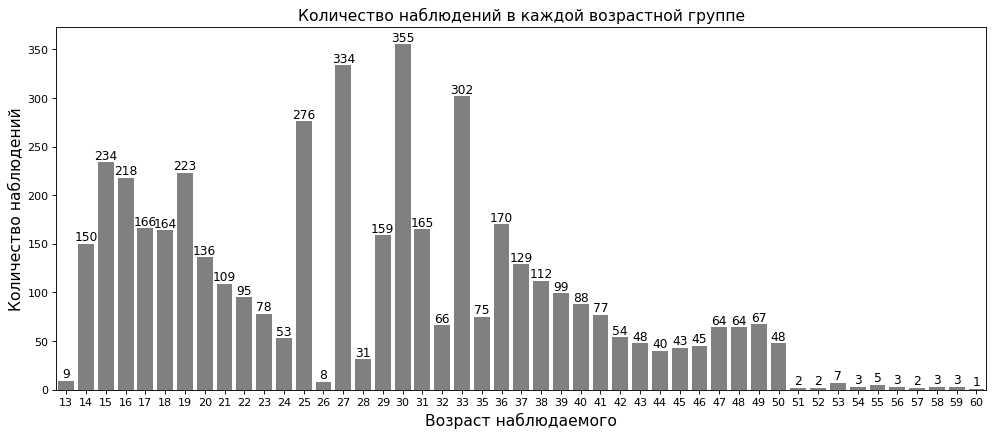

In [12]:
plt.figure(figsize=(15,6), dpi= 80)
sns.barplot(x='age', y='count_of_observations', data=age_bar, color='gray')
for i, val in enumerate(age_bar['count_of_observations'].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom',
             fontdict={'fontweight':500, 'size':11})
plt.title('Количество наблюдений в каждой возрастной группе',size=14)
plt.gca().set_xticklabels(age_bar['age'])
plt.xlabel('Возраст наблюдаемого',size=14)
plt.ylabel('Количество наблюдений',size=14)

In [13]:
def make_pie(table,col1,col2,titl):
    fig = px.pie(table, values=col2, names=col1, title=titl)
    fig.show()
make_pie(age_bar,'age','count_of_observations','Количество наблюдений в каждой возрастной группе')

#### Количество наблюдений в группах распределено неравномерно.

In [14]:
# посмотрим в каких группах больше всего наблюдений
age_bar.sort_values('count_of_observations',ascending=False)[0:10]

age  count_of_observations
17  30                    355
14  27                    334
20  33                    302
12  25                    276
2   15                    234
6   19                    223
3   16                    218
22  36                    170
4   17                    166
18  31                    165

#### Больше всего наблюдений мы имеем в возрастных группах 30, 27, 33 - почему так много наблюдаемых именно в этой возрастной категории?!

In [15]:
age_bar2=df1.pivot_table(index='klass', columns='age', values='feature1',aggfunc='count')\
.reset_index().T.fillna(0)
age_bar2 = age_bar2.drop(index=['klass']).reset_index()

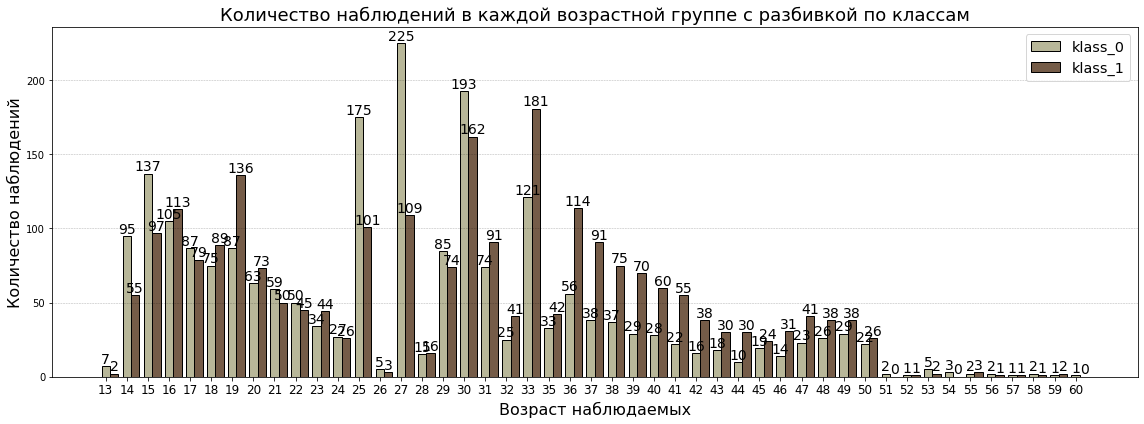

In [16]:
length = len(age_bar2)
x_labels = age_bar2['age'].unique().tolist()
fig, ax = plt.subplots(figsize=(16,6))
width = 0.4 # width of bar
x = np.arange(length)
#строим бар
ax.bar(x, age_bar2[0], width, color='#B8B799', label='klass_0',ec='black' )
#делаем подписи
for i, val in enumerate(age_bar2[0].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom',
             fontdict={'fontweight':500, 'size':14})
ax.bar(x + width, age_bar2[1], width, color='#755C48', label='klass_1',ec='black')
for i, val in enumerate(age_bar2[1].values):
    plt.text(i+width, val, int(val), horizontalalignment='center', verticalalignment='bottom', 
             fontdict={'fontweight':500, 'size':14})   

ax.set_xticks(x)
ax.set_xticklabels(x_labels,fontsize='large')
ax.set_xlabel('Возраст наблюдаемых',fontsize=16)
ax.set_ylabel('Количество наблюдений',fontsize=16)
ax.set_title('Количество наблюдений в каждой возрастной группе с разбивкой по классам',fontsize=18)
ax.legend(fontsize='x-large')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
fig.tight_layout()
plt.show()

### Вывод:
1. Количество наблюдений в группах распределено неравномерно.
2. Больше всего наблюдений мы имеем в возрастных группах 30, 27, 33 - почему так много наблюдаемых именно в этой возрастной категории?
3. У наблюдаемых в возрасте до 31 года klass_0 преобладает над klass_1, после 31 года наоборот. Определенно существует какая-то связь c возрастом.

4. Cледует возврастные группы соотнести в категории. 
    Т.к. на собеседование речь была про влияние на людей (условно НЛП), то можно было разбить на группы соответствующие возрасту психического развития личности. Немного погуглив теорию по периодизации писхического развития, таких групп не так уж и много. В соответсвии с трудами  Д. Б. Эльконина [1] категоризация возможна до 17 лет.
    
    Поэтому  опираясь на то, что Министерство здравоохранения в целом про медицину, то разобьем на биологический возраст людей. Возрастная периодизация в медицине опирается на соответствующие возрасту анатомические и физиологические особенности организма. Условные периоды биологического возраста [2] подходящие под наш исходник следующие:
    
Подростковый возраст — от 13 до 16 лет (муж.); от 12 до 15 лет (жен.)

Юношеский возраст — от 17 до 21 года (муж.); от 16 до 20 лет (жен.)

Средний возраст

первый период — от 22 до 35 года (муж.); от 21 до 35 лет (жен.)

второй период — от 36 до 60 года (муж.); от 36 до 55 лет (жен.)

    
У нас нет в исходниках разделения на мужчин и женщин, поэтому заведем единый возрастной словарь со следующими категориями 'teenager':'13-17','youthful':'18-21','middle_1':'22-35','middle_2':'36-60'.

<a name="3.2"></a><br/>
<font size="4"><b>3.2. Категоризация возрастных групп</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [17]:
dict_category_of_age={}
for name in df1['age'].unique():
    if 13 <= name <= 16:
        dict_category_of_age[name]='teenager'
    elif 17 <= name <= 21:
        dict_category_of_age[name]='youthful'
    elif 22 <= name <= 35:
        dict_category_of_age[name]='middle_1'
    else:
        dict_category_of_age[name]='middle_2'

In [18]:
# введем в исходник столбец age_category
df1['age_category']=''

# с помощью цикла разметим на возрастные категории
for i in range(len(df1)):
    df1.loc[i,'age_category']=dict_category_of_age[df1.loc[i,'age']]
df1['age_category'].unique()

array(['teenager', 'youthful', 'middle_1', 'middle_2'], dtype=object)

In [19]:
age_pie = df1.groupby('age_category').agg({'age':'count'}).reset_index()
age_pie = age_pie.rename(columns = {'age':'count_of_observations'})
age_pie 

age_category  count_of_observations
0     middle_1                   1997
1     middle_2                   1179
2     teenager                    611
3     youthful                    798

In [20]:
make_pie(age_pie,'age_category','count_of_observations','Количество наблюдений в каждой возрастной группе')

#### Больше всего наблюдений в группе людей со средний возрастом первого периода — от 22 до 35 лет 

<a name="4."></a><br/>
<font size="5"><b>4. Построение прогнозных моделей</b></font><br/>
<a name="4.1"></a><br/>
<font size="4"><b>4.1. Определение лучшей модели для построения</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Для начала преобразуем столбец 'age_category' в цифровой вид, для этого воспользуемся вcтроенной функцией pandas get_dummies. Которая на выходе нам даст бинарные признаки категории.

In [21]:
df1 = pd.get_dummies(df1) 

In [22]:
df1.head(1)

klass  age  feature1  feature2  feature3  feature4  feature5  feature6  \
0      0   13  0.506822  0.572237   0.56328  0.564596  0.673946       1.0   

   feature7  feature8  ...  feature123  feature124  feature125  feature126  \
0  0.639703  0.493562  ...    0.592213    0.646772    0.578132    0.409359   

   feature127  feature128  age_category_middle_1  age_category_middle_2  \
0    0.617043    0.684861                      0                      0   

   age_category_teenager  age_category_youthful  
0                      1                      0  

[1 rows x 134 columns]

Итого нам необходимо предсказать 0 или 1 в зависимости от тех признаков, которые мы имеем.

Т.е. переходим в плоскоть обучение с учителем, бинарная классификация. 

На выбор у нас следующие методы:

* Логистическая регрессия	sklearn.linear_model.LogisticRegression()
* Дерево принятия решений	sklearn.tree.DecisionTreeClassifier()
* Случайный лес	sklearn.ensemble.RandomForestClassifier()
* Градиентный бустинг	sklearn.ensemble.GradientBoostingClassifier(), xgboost.XGBClassifier

Прогоним все - посмотрим лучшие оценки. Поехали.

In [23]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df1.drop('klass', axis = 1)
y = df1['klass']

# разделим модель на обучающую и валидационную выборку классическим методом 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=666)

models = [RandomForestClassifier(),  # случайный лес
          GradientBoostingClassifier(),  # ГБ
          LogisticRegression(),  # логистическая регрессия
          DecisionTreeClassifier() # Дерево принятия решений
         ]

# стандартизируем данные для минимизации ошибки
scaler = StandardScaler()
scaler.fit(X_train)

# преобразуем обучающую и валидационную выборку
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [24]:
#создаем временные структуры
TestModels = DataFrame()
tmp = {}
#для каждой модели из списка
for model in models:
    #получаем имя модели
    m = str(model)
    tmp['Model'] = m[:m.index('(')]    
    #для каждого столбцам результирующего набора
    #обучаем модель
    model.fit(X_train_st, y_train) 
    #вычисляем метрики оценки качества
    pr = model.predict(X_test_st)
    tmp['recall_score'] = recall_score(y_test, pr)
    tmp['precision_score'] = precision_score(y_test, pr)
    tmp['accuracy'] = accuracy_score(y_test, pr)
    tmp['f1_score'] = f1_score(y_test, pr)
    tmp['roc_auc_score'] = roc_auc_score(y_test, model.predict_proba(X_test_st)[:,1])
    #записываем данные и итоговый DataFrame
    TestModels = TestModels.append([tmp])
TestModels.set_index('Model', inplace=True)
TestModels.sort_values(by = 'recall_score', ascending = False)

recall_score  precision_score  accuracy  f1_score  \
Model                                                                           
GradientBoostingClassifier      0.919840         0.870968  0.882225  0.894737   
LogisticRegression              0.917836         0.889320  0.893130  0.903353   
RandomForestClassifier          0.907816         0.859583  0.869138  0.883041   
DecisionTreeClassifier          0.741483         0.775681  0.742639  0.758197   

                            roc_auc_score  
Model                                      
GradientBoostingClassifier       0.954469  
LogisticRegression               0.948653  
RandomForestClassifier           0.939225  
DecisionTreeClassifier           0.742751

### Вывод: 
Лучшая модель - логистистической регрессии, по всем метрикам привосходит другие модели.Исключением является показатели метрик recall_score и roc_auc_score в методе градиентного бустинга, модель которого тоже показала хорошие результаты.

Худшия модель DecisionTreeClassifier по всем величинам метрик.

Как же определить какая метрика для нас важнее?! 
Если мы прогнозируем вероятность наличия у пациента опасного редкого заболевания как бинарную классификацию (0 — здоров, 1 — болен) При условии, что дополнительное более детальное обследование НЕ причиняет вреда здоровью пациента, то оценка recall_score самая важная.  Не так страшно, если модель спрогнозирует заболевание, а после вторичного обследования окажется, что у пациента всё-таки нет этой болезни, чем если мы пропустим реальный случай (гораздо более негативный сценарий).

<a name="4.2"></a><br/>
<font size="4"><b>4.2. Построение модели градиентный бустинг</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [25]:
# обучим финальную модель
final_model = GradientBoostingClassifier()
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)
importances = final_model.feature_importances_
# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
df_model = pd.DataFrame(importances, X.columns.tolist(), columns=['weight'])
df_model['weight'] = df_model['weight'].apply(lambda x: abs(x))
df_model = df_model.sort_values(by='weight', ascending=False)
print('\n ТОП-20 коэффициентов признаков в оптимальной модели Градиентный бустинг')
df_model[:20]


 ТОП-20 коэффициентов признаков в оптимальной модели Градиентный бустинг


weight
feature21   0.172953
feature126  0.082558
feature1    0.074494
feature48   0.055336
feature87   0.045888
feature52   0.042931
feature46   0.041609
age         0.041481
feature73   0.029232
feature94   0.026521
feature111  0.025922
feature64   0.023355
feature113  0.019659
feature80   0.017969
feature121  0.014523
feature123  0.013931
feature98   0.013735
feature16   0.013672
feature62   0.012853
feature116  0.012605

In [26]:
# запишем в список 20ку важных признаков для модели градиентного бустинга
list_of_important_features_of_gradbust_model = df_model[:20].index.tolist()

### Вывод:

Отсортировав признаки по важности для точной работы нашего алгоритма, мы увидели, что feature21 имеет наибольший вес 0.172953. Можно сделать вывод, что на нашу метрику klass имеет сильное влияние feature21.

Замыкает 10ку параметр feature94.

<a name="4.3"></a><br/>
<font size="4"><b>4.3. Построение модели логистической регрессии</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

In [27]:
# обучим финальную модель
final_model_lr = LogisticRegression(random_state=666)
final_model_lr.fit(X_train_st, y_train)
y_pred = final_model_lr.predict(X_test_st)

# создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
df_model_lr = pd.DataFrame(final_model_lr.coef_.T, X.columns.tolist(), columns=['weight'])
df_model_lr['weight'] = df_model_lr['weight'].apply(lambda x: abs(x))
df_model_lr = df_model_lr.sort_values(by='weight', ascending=False)
print('\nКоэффициенты признаков в оптимальной функции логистической регрессии:')
df_model_lr[:20]


Коэффициенты признаков в оптимальной функции логистической регрессии:


weight
feature83   0.859105
feature52   0.740173
feature48   0.643263
age         0.621961
feature117  0.541968
feature21   0.529258
feature89   0.517505
feature2    0.455723
feature46   0.453971
feature60   0.422979
feature113  0.421905
feature126  0.409959
feature111  0.382830
feature14   0.361597
feature124  0.354952
feature87   0.346942
feature86   0.340006
feature24   0.336872
feature118  0.331638
feature69   0.322111

In [28]:
# запишем в список 20ку важных признаков для логистической модели
list_of_important_features_of_log_model = df_model_lr[:20].index.tolist()

### Вывод:

Отсортировав признаки по важности для точной работы нашего алгоритма, мы увидели, что feature83 имеет наибольший вес 0.859105. Можно сделать вывод, что на нашу метрику klass имеет сильное влияние feature83.

Замыкает 20ку параметр feature69.

In [29]:
important_features = []
for name in list_of_important_features_of_log_model:
    if name in list_of_important_features_of_gradbust_model:
        important_features.append(name)
print('{} - важных совпадающих признаков из каждой 20ки, для моделей Градиентного бустинга и Логистической регрессии'.format(len(important_features)))
important_features

9 - важных совпадающих признаков из каждой 20ки, для моделей Градиентного бустинга и Логистической регрессии


['feature52',
 'feature48',
 'age',
 'feature21',
 'feature46',
 'feature113',
 'feature126',
 'feature111',
 'feature87']

<a name="4.4"></a><br/>
<font size="4"><b>4.4 Выводы по построенным моделям для целевого классификатора</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

### Вывод по разделу:

1. Лучшая модель - логистистической регрессии, по всем метрикам привосходит другие модели.Исключением является показатели метрик recall_score и roc_auc_score в методе градиентного бустинга, модель которого тоже показала хорошие результаты. Худшия модель DecisionTreeClassifier по всем величинам метрик.


2. При построении модели градиентного бустинга выявили, что на нашу метрику klass оказывает сильное влияние признак feature21. ТОП-20 важных признаков сохранены в список list_of_important_features_of_gradbust_model


3. При построении модели логистической регрессии выявили, что на нашу метрику klass оказывает сильное влияние признак feature83. ТОП-20 важных признаков сохранены в список list_of_important_features_of_log_model


4. Выяснили, что имеется 10 - важных совпадающих признаков из каждой 20ки, для моделей Градиентного бустинга и Логистической регрессии. Сохранены в список important_features.

<a name="4.5"></a><br/>
<font size="4"><b>4.5 Прогнозное отнесение к возрастной группе по имеющимся признакам</b></font><br/>
[<font size="2">(к содержанию)</font>](#1common.)

Т.е. мы имеем ту же самую задачу бинарной классификации для каждой из сформированных возрастных категорий:
#### 'teenager':'13-17','youthful':'18-21','middle_1':'22-35','middle_2':'36-60'.

По сути нам нужно повторить раздел 4.1 исключение лишь в том, что столбцов поменьше. Тут пожалел, что сразу не обренул все действия раздела в функцию.

Прежде, чем приступать проведем еще один анализ. Ответим на вопрос различаются ли признаки в одной возрастной категории в зависимости от классификатора. Вангую, что конечно различаются!

Вы наверное хотите спросить, почему дисплоты не построил раньше. Если признаки имели бы одинаковые значения не смотря на классификатор, а только из-за значений возраста, то не было бы смысла в задаче. 

Докажем это и построим дисплоты.

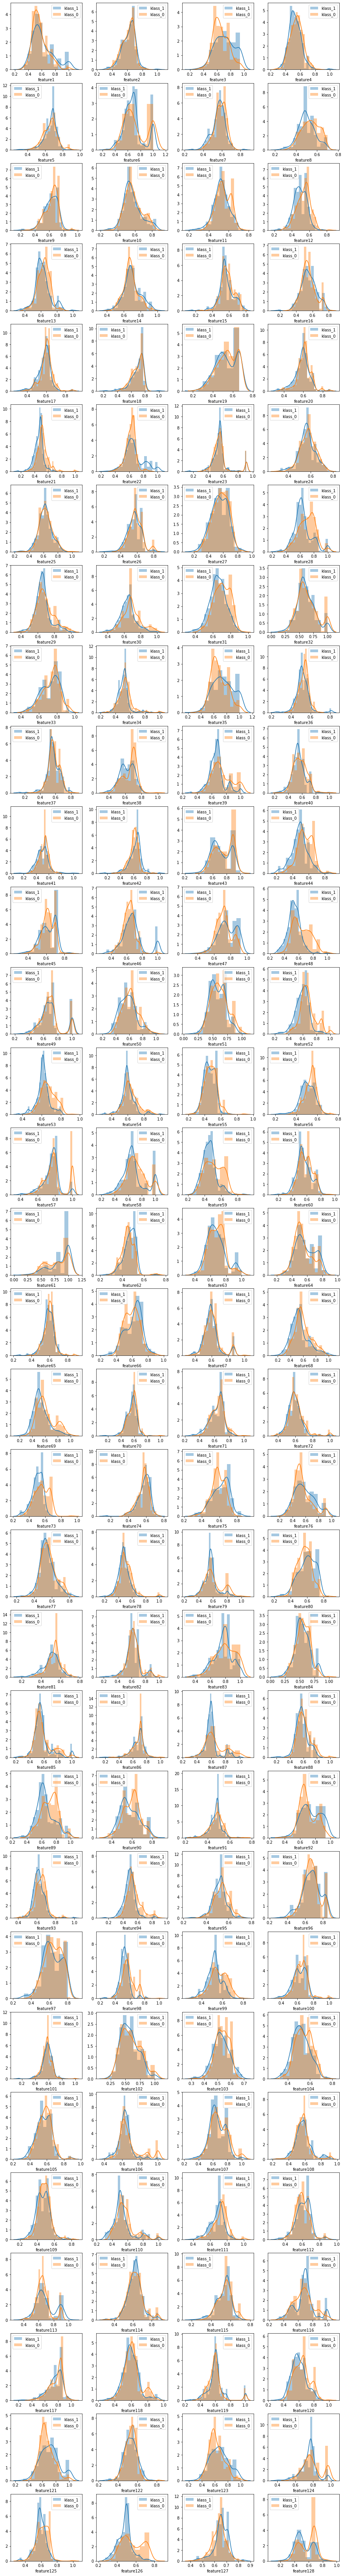

In [30]:
# посмотрим на распределение каждого признака по двум группам
fig, axs = plt.subplots(32,4, figsize=(15, 120))
ax_iter = iter(axs.flat)
for col in df1.drop(['klass','age','age_category_middle_1','age_category_middle_2',
                     'age_category_youthful','age_category_teenager'], axis=1).columns:
    ax = next(ax_iter)
    sns.distplot(df1.query('age_category_teenager==1 & klass==1')[col], ax=ax)
    sns.distplot(df1.query('age_category_teenager==1 & klass==0')[col], ax=ax)
    ax.legend(labels=['klass_1', 'klass_0'])

Видим, различия по всем признакам, есть в зависимости от классификатора. По некоторым признакам,есть совпадения по контору кривой, например признак feature2.
Можно провести статистические тесты по выборкам, и доказать, что статистических различий в ген.совокупностях разных классификторов признака feature2 по возрастной категории 'teenager' - не имеется.

Это была подводка к тому, что если мы хотим прогнозировать возрастную категорию, нам необходимо разделять выборки по признаку классификатора.

А лучше, сначала построить модель по каждому из классификаторов, а затем сравнить какая из них лучше моделирует возраст. Поехали.

In [31]:
# пишим функцию для выявления лучшей модели

def find_best_model(target_age_category,klass_type):
    spisok = ['age','age_category_middle_1','age_category_middle_2','age_category_youthful','age_category_teenager']
    #spisok.remove(target_age_category) 
    df_test=df1.query('klass==@klass_type')
    # разделим наши данные на признаки (матрица X) и целевую переменную (y)
    X = df_test.drop(spisok, axis = 1)
    y = df_test[target_age_category]
    #print(y)
    # разделим модель на обучающую и валидационную выборку классическим методом 80/20
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=666)
    # стандартизируем данные для минимизации ошибки
    scaler = StandardScaler()
    scaler.fit(X_train)

    # преобразуем обучающую и валидационную выборку
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    #создаем временные структуры
    TestModels = DataFrame()
    tmp = {}
    #для каждой модели из списка
    for model in models:
        #получаем имя модели
        m = str(model)
        tmp['Model'] = m[:m.index('(')]    
        #для каждого столбцам результирующего набора
        #обучаем модель
        model.fit(X_train_st, y_train) 
        #вычисляем метрики оценки качества
        pr = model.predict(X_test_st)
        tmp['precision_score'] = precision_score(y_test, pr)
        tmp['recall_score'] = recall_score(y_test, pr)
        tmp['accuracy'] = accuracy_score(y_test, pr)
        
        #записываем данные и итоговый DataFrame
        TestModels = TestModels.append([tmp])
    TestModels.set_index('Model', inplace=True)
    print('*'*100)
    print('Выбор лучшей модели для возрастной группы', target_age_category, 'где классификатор равен',klass_type)
    print(TestModels.sort_values(by = 'precision_score', ascending = False))
    print('-'*100)

In [32]:
for target_age_category_ in ['age_category_middle_1','age_category_middle_2','age_category_youthful','age_category_teenager']:
    find_best_model(target_age_category_,0)
    find_best_model(target_age_category_,1)

****************************************************************************************************
Выбор лучшей модели для возрастной группы age_category_middle_1 где классификатор равен 0
                            precision_score  recall_score  accuracy
Model                                                              
GradientBoostingClassifier         0.700000      0.821596  0.741419
RandomForestClassifier             0.698690      0.751174  0.720824
LogisticRegression                 0.696203      0.774648  0.725400
DecisionTreeClassifier             0.687500      0.723005  0.704805
----------------------------------------------------------------------------------------------------
****************************************************************************************************
Выбор лучшей модели для возрастной группы age_category_middle_1 где классификатор равен 1
                            precision_score  recall_score  accuracy
Model                                    

Видим, что в большинстве случаев у модели RandomForestClassifier лучший результат по метрике наведение.

Найдем лучшие фичи для определения возраста. Оформим еще одну функцию find_best_features

In [33]:
best_features = []
dict_best_features = {}
def find_best_features(target_age_category,klass_type):
    spisok = ['age','age_category_middle_1','age_category_middle_2','age_category_youthful','age_category_teenager']
    #spisok.remove(target_age_category) 
    df_test=df1.query('klass==@klass_type')
    # разделим наши данные на признаки (матрица X) и целевую переменную (y)
    X = df_test.drop(spisok, axis = 1)
    y = df_test[target_age_category]
    # разделим модель на обучающую и валидационную выборку классическим методом 80/20
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=666)
    # стандартизируем данные для минимизации ошибки
    scaler = StandardScaler()
    scaler.fit(X_train)

    # преобразуем обучающую и валидационную выборку
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    # обучим финальную модель
    final_ml = RandomForestClassifier()
    final_ml.fit(X_train_st, y_train)
    y_pred = final_ml.predict(X_test_st)
    importances = final_ml.feature_importances_
    # создадим датафрейм с именами признаков и их важностью и выведем его по убыванию важности
    df_ml = pd.DataFrame(importances, X.columns.tolist(), columns=['weight'])
    df_ml['weight'] = df_ml['weight'].apply(lambda x: abs(x))
    df_ml = df_ml.sort_values(by='weight', ascending=False)
    best_features.append(df_ml[:20].index.tolist())
    dict_best_features[(target_age_category+'_klass_'+str(klass_type))]=df_ml[:20].index.tolist()
    print('*'*100)
    print('\n ТОП-20 коэффициентов признаков в модели RandomForestClassifier для',target_age_category, 'где классификатор равен',klass_type)
    print(df_ml[:20])
    print('-'*100)

In [34]:
for target_age_category_ in ['age_category_middle_1','age_category_middle_2','age_category_youthful','age_category_teenager']:
    find_best_features(target_age_category_,0)
    find_best_features(target_age_category_,1)

****************************************************************************************************

 ТОП-20 коэффициентов признаков в модели RandomForestClassifier для age_category_middle_1 где классификатор равен 0
              weight
feature61   0.031619
feature65   0.027809
feature19   0.026533
feature30   0.020304
feature6    0.014798
feature29   0.014706
feature14   0.014576
feature49   0.013949
feature36   0.013712
feature21   0.012120
feature7    0.011874
feature22   0.011850
feature71   0.011834
feature98   0.011819
feature95   0.010829
feature26   0.010488
feature103  0.009955
feature84   0.009941
feature70   0.009916
feature106  0.009698
----------------------------------------------------------------------------------------------------
****************************************************************************************************

 ТОП-20 коэффициентов признаков в модели RandomForestClassifier для age_category_middle_1 где классификатор равен 1
              weight
f

In [35]:
# признаки которые были весомы при построениии модели возрастной категории.
dict_best_features

{'age_category_middle_1_klass_0': ['feature61',
  'feature65',
  'feature19',
  'feature30',
  'feature6',
  'feature29',
  'feature14',
  'feature49',
  'feature36',
  'feature21',
  'feature7',
  'feature22',
  'feature71',
  'feature98',
  'feature95',
  'feature26',
  'feature103',
  'feature84',
  'feature70',
  'feature106'],
 'age_category_middle_1_klass_1': ['feature61',
  'feature70',
  'feature53',
  'feature127',
  'feature43',
  'feature110',
  'feature4',
  'feature42',
  'feature91',
  'feature116',
  'feature112',
  'feature65',
  'feature85',
  'feature54',
  'feature73',
  'feature10',
  'feature29',
  'feature11',
  'feature81',
  'feature14'],
 'age_category_middle_2_klass_0': ['feature34',
  'feature103',
  'feature95',
  'feature21',
  'feature71',
  'feature94',
  'feature100',
  'feature61',
  'feature122',
  'feature7',
  'feature81',
  'feature56',
  'feature128',
  'feature62',
  'feature108',
  'feature26',
  'feature8',
  'feature25',
  'feature54',
  'featu

Набор фич для определения возраста для каждой возрастной категории мы записали в словарь dict_best_features.
Попробуем определить какие фичи встречаются чаще всего во всех возрастных категориях, и есть ли такие.
Сделаем словарь счетчик best_features_new.

In [36]:
features_list = []
for name in list(dict_best_features.keys()):
    features_list += dict_best_features[name]

best_features_new = Counter(features_list)
graf = pd.DataFrame.from_dict(best_features_new,orient='index').reset_index().sort_values(0,ascending=False)

In [37]:
best_features_new

Counter({'feature61': 8,
         'feature65': 7,
         'feature19': 6,
         'feature30': 4,
         'feature6': 4,
         'feature29': 3,
         'feature14': 2,
         'feature49': 3,
         'feature36': 2,
         'feature21': 4,
         'feature7': 3,
         'feature22': 3,
         'feature71': 5,
         'feature98': 1,
         'feature95': 5,
         'feature26': 3,
         'feature103': 2,
         'feature84': 2,
         'feature70': 5,
         'feature106': 3,
         'feature53': 4,
         'feature127': 3,
         'feature43': 1,
         'feature110': 2,
         'feature4': 1,
         'feature42': 4,
         'feature91': 1,
         'feature116': 3,
         'feature112': 5,
         'feature85': 1,
         'feature54': 4,
         'feature73': 1,
         'feature10': 1,
         'feature11': 1,
         'feature81': 3,
         'feature34': 4,
         'feature94': 2,
         'feature100': 1,
         'feature122': 2,
         'feature56'

Text(0, 0.5, 'Сколько раз встречался')

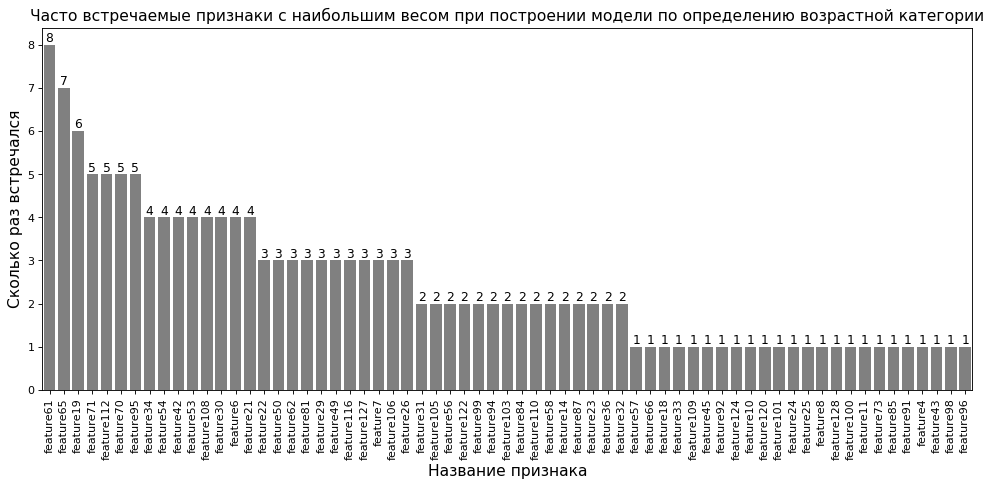

In [38]:
plt.figure(figsize=(15,6), dpi= 80)
sns.barplot(x='index', y=0, data=graf, color='gray')
for i, val in enumerate(graf[0].values):
    plt.text(i, val, int(val), horizontalalignment='center', verticalalignment='bottom',
             fontdict={'fontweight':500, 'size':11})
plt.title('Часто встречаемые признаки с наибольшим весом при построении модели по определению возрастной категории',size=14)
plt.gca().set_xticklabels(graf['index'],rotation=90)
plt.xlabel('Название признака',size=14)
plt.ylabel('Сколько раз встречался',size=14)

Наиболее весомые признаки для построения модели возрастной категории следющие:
feature61, feature19, feature34, feature32, feature65, feature42,feature70, feature71

<a name="5."></a><br/>
<font size="5"><b>Шаг 5. Выводы по проекту</b></font>.<br/>
[<font size="2">(к содержанию)</font>](#1common.)

<br/>
<div class="col-md-3">
  <ul class="nav flex-column nav-pills">  
    <li class="active"><a class="nav-link" id="home-tab" data-toggle="pill" href="#output2" role="tab" aria-controls="output2" aria-selected="false">Баг-репорт</a></li>    
    <li><a class="nav-link" id="profile-tab" data-toggle="pill" href="#output3" role="tab" aria-controls="output3" aria-selected="false">Результаты Анализа</a></li>
    <li><a class="nav-link" id="profile-tab" data-toggle="pill" href="#output4" role="tab" aria-controls="output4" aria-selected="false">Выполнена возрастная категоризация</a></li>
    <li><a class="nav-link" id="contact-tab" data-toggle="pill" href="#output" role="tab" aria-controls="output" aria-selected="false">Определение моделей для целевого классификатора</a></li>
    <li><a class="nav-link" id="contact-tab" data-toggle="pill" href="#output5" role="tab" aria-controls="output5" aria-selected="false">Лучшие признаки для целевого классификатора</a></li>
    <li><a class="nav-link" id="contact-tab" data-toggle="pill" href="#output6" role="tab" aria-controls="output5" aria-selected="false">Выбор модели и лучших признаков при построении возрастного прогноза</a></li>
    <li><a class="nav-link" id="contact-tab" data-toggle="pill" href="#output7" role="tab" aria-controls="output7" aria-selected="false">Используемые источники</a></li>
   
</ul>
</div>


<div class="tab-content">
<div id="output2" class="tab-pane fade in active">
    <h3 style="margin-left:270px">Баг-репорт</h3>
    <p style="margin-left:270px">        
нашли 2,5% дубликатов строк, необходимо задать вопрос ответственному за данные:
        <br> <br>
-- допустимо ли, у пациентов одного возраста совпадение показателей по 128 признакам;
        <br> <br>
-- может быть тут ошибка вида - один и тот же пациент имеет несколько уникальных id.
        <br> <br>
Для дальнейшего анализа происхождения ошибки, список id пациентов имеющие одинаковые признаки сохранены тут => ids_duplicates, возрастная категория людей в которых есть дубли - от 47 до 50 лет.
        <br> <br>

</p>
</div>

  <div id="output3" class="tab-pane fade">
      <h3 style="margin-left:270px">Результаты Анализа</h3>
    <p style="margin-left:270px"> 
1. Количество наблюдений в группах распределено неравномерно.
        <br> <br>
2. Больше всего наблюдений мы имеем в возрастных группах 30, 27, 33 - почему так много наблюдаемых именно в этой возрастной категории?
        <br> <br>
3. У наблюдаемых в возрасте до 31 года klass_0 преобладает над klass_1, после 31 года наоборот. Определенно существует какая-то связь c возрастом.
        <br> <br>
4. Cледует возврастные группы соотнести в категории. 
</p>
  </div>

<div id="output4" class="tab-pane fade">
      <h3 style="margin-left:270px">Выполнена возрастная категоризация</h3>
    
<p style="margin-left:270px"> Т.к. на собеседование речь была про влияние на людей (условно НЛП), то можно было разбить на группы соответствующие возрасту психического развития личности. Немного погуглив теорию по периодизации писхического развития, таких групп не так уж и много. В соответсвии с трудами  Д. Б. Эльконина [1] категоризация возможна до 17 лет.
        <br> <br>    
    Поэтому  опираясь на то, что Министерство здравоохранения в целом про медицину, то разобьем на биологический возраст людей. Возрастная периодизация в медицине опирается на соответствующие возрасту анатомические и физиологические особенности организма. Условные периоды биологического возраста [2] подходящие под наш исходник следующие:
        <br> <br>    
Подростковый возраст — от 13 до 16 лет (муж.); от 12 до 15 лет (жен.)
        <br> <br>
Юношеский возраст — от 17 до 21 года (муж.); от 16 до 20 лет (жен.)
        <br> <br>
Средний возраст
        <br> <br>
первый период — от 22 до 35 года (муж.); от 21 до 35 лет (жен.)
        <br> <br>
второй период — от 36 до 60 года (муж.); от 36 до 55 лет (жен.)
        <br> <br>       
У нас нет в исходниках разделения на мужчин и женщин, поэтому заведем единый возрастной словарь со следующими категориями 'teenager':'13-17','youthful':'18-21','middle_1':'22-35','middle_2':'36-60'.
        <br> <br>    
        Больше всего наблюдений в группе людей со средний возрастом первого периода — от 22 до 35 лет
        <br> <br>    
  </p>
  </div>
    
                    
<div id="output" class="tab-pane fade">
      <h3 style="margin-left:270px">Определение моделей для целевого классификатора</h3>
      <p>
        <p style="margin-left:270px">  
          Лучшая модель - логистистической регрессии, по всем метрикам привосходит другие модели.Исключением является показатели метрик recall_score и roc_auc_score в методе градиентного бустинга, модель которого тоже показала хорошие результаты.
<br><br>
Худшия модель DecisionTreeClassifier по всем величинам метрик.
<br><br>
Как же определить какая метрика для нас важнее?! 
Если мы прогнозируем вероятность наличия у пациента опасного редкого заболевания как бинарную классификацию (0 — здоров, 1 — болен) При условии, что дополнительное более детальное обследование НЕ причиняет вреда здоровью пациента, то оценка recall_score самая важная.  Не так страшно, если модель спрогнозирует заболевание, а после вторичного обследования окажется, что у пациента всё-таки нет этой болезни, чем если мы пропустим реальный случай (гораздо более негативный сценарий)."<br><br>

</p>
            </div>
            <div id="output5" class="tab-pane fade">
      <h3 style="margin-left:270px">Лучшие признаки для целевого классификатора</h3> 
      <p>
        <p style="margin-left:270px">  
          1. Лучшая модель - логистистической регрессии, по всем метрикам привосходит другие модели.Исключением является показатели метрик recall_score и roc_auc_score в методе градиентного бустинга, модель которого тоже показала хорошие результаты. Худшия модель DecisionTreeClassifier по всем величинам метрик.
        <br> <br>   
2. При построении модели градиентного бустинга выявили, что на нашу метрику klass оказывает сильное влияние признак feature21. ТОП-20 важных признаков сохранены в список list_of_important_features_of_gradbust_model
        <br> <br>   
3. При построении модели логистической регрессии выявили, что на нашу метрику klass оказывает сильное влияние признак feature83. ТОП-20 важных признаков сохранены в список list_of_important_features_of_log_model
        <br> <br>   
4. Выяснили, что имеется 10 - важных совпадающих признаков из каждой 20ки, для моделей Градиентного бустинга и Логистической регрессии. Сохранены в список important_features.
        <br> <br>        
</p>
            </div>
             <div id="output6" class="tab-pane fade">
      <h3 style="margin-left:270px">Выбор модели и лучших признаков при построении возрастного прогноза</h3> 
      <p>
        <p style="margin-left:270px">  
            В большинстве случаев у модели RandomForestClassifier лучший результат по метрике наведение.
                  <br> <br>  
         Набор фич для определения возраста для каждой возрастной категории мы записали в словарь dict_best_features. 
                 <br> <br>  
         Наиболее весомые признаки для построения модели возрастной категории следющие:
feature61, feature19, feature34, feature32, feature65, feature42,feature70, feature71 
        <br> <br>  
</p>
</div>

  <div id="output7" class="tab-pane fade">
      <h3 style="margin-left:270px">Используемые источники</h3> 
      <p>
        <p style="margin-left:270px">  
         <a> [1] https://ru.wikipedia.org/wiki/Периодизация_психического_развития_Д._Б._Эльконина</a><br>
                 <a> [2] https://ru.wikipedia.org/wiki/Возрастная_периодизация</a> <br>
        
</p>
</div>
</div>
            
            
           